# **Integration of Solutions**

This is the merged solutions notebook which was originally written in spanish.

The goal of this notebook is to test the classifier together with the segmentator.

In [23]:
import pickle
import sys
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import morphology, measure
from skimage import filters, color
import tqdm.auto as tqdm
from PIL import Image

added_paths = [os.path.join(os.getcwd(), '..', 'src', 'utils'),
               os.path.join(os.getcwd(), '..', 'src'),]

for added_path in added_paths:
    if added_path not in sys.path:
        sys.path.insert(0, added_path)

from components.data_transformation import DataTransformationConfig, DataTransformer

## **Auxiliar Functions**:


En esta sección se encuentran definidas algunas funciones extraidas del notebook de clasificación y segmentación, las cuales son utilizadas para mostrar un flujo básico de uso para detectar piscinas en una imagen tomada desde el aire.

In [24]:
def draw_mask_contour(image, mask):  
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = image.copy()
    cv2.drawContours(out, contours, -1, (0,255,0), 2)
    return out


class pipeline:
    def __init__(self) -> None:
        self.operations = []
    
    def __repr__(self):
        operation_names = [op.__name__ for op in self.operations][::-1]
        par = [')' for _ in range(len(self.operations) - 1)]
        return f"ImageProcessingPipeline: {'('.join(operation_names)}(image{''.join(par)})"

    def add_operation(self, operation):
        self.operations.append(operation)
    
    def remove_operation(self, operation):
        self.operations.remove(operation)
    
    def apply(self, image, verbose=False):
        img = image.copy()
        if verbose:
            plt.figure()
            plt.title("Original")
            plt.imshow(img)
            plt.show()
        for operation in tqdm.tqdm(self.operations, 
                                   desc="Processing", 
                                   unit="operation",
                                   disable=True):
            img = operation(img)
            if(verbose):
                plt.figure()
                plt.imshow(img)
                plt.show()
        return img

In [25]:
def image_matching(image, mask):
    """
    This function computes the matching of the image by the mask
    """
    intersection = np.sum(np.where(image * mask > 0, 1, 0))
    return intersection / np.sum(np.where(mask > 0, 1, 0))

def jaccard_index(imagen_referencia, imagen_segmentacion):
    # Convertir las imágenes a arreglos NumPy binarios
    referencia_binaria = np.asarray(imagen_referencia).astype(bool)
    segmentacion_binaria = np.asarray(imagen_segmentacion).astype(bool)

    # Calcular el tamaño de la intersección y la unión
    interseccion = np.logical_and(referencia_binaria, segmentacion_binaria)
    union = np.logical_or(referencia_binaria, segmentacion_binaria)

    # Calcular el índice de Jaccard
    jaccard = np.sum(interseccion) / np.sum(union)

    return jaccard

In [26]:
def otsu_threshold(image):
    gray = color.rgb2gray(np.array(image))
    threshold = filters.threshold_otsu(gray)
    return gray > threshold

def simple_threshold(gray, threshold=0):
    return gray > threshold

def kmeans_segmentation(image, k = 3):
    pixel_vals = image.reshape((-1,3))

    # Convert to float type
    pixel_vals = np.float32(pixel_vals)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    
    # Perform the k-means clustering
    retval, labels, centers = cv2.kmeans(pixel_vals, 
                                         k, None, criteria, 10, 
                                         cv2.KMEANS_PP_CENTERS)
    
    # convert data into 8-bit values
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    
    # reshape data into the original image dimensions
    segmented_image = segmented_data.reshape((image.shape))
    
    return segmented_image

def kmeans_segmentation2(image_bgr, k = 3):
    # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
    image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    pixel_vals = image.reshape((-1,3))

    # Convert to float type
    pixel_vals = np.float32(pixel_vals)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    
    # Perform the k-means clustering
    _, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, 
                                         cv2.KMEANS_RANDOM_CENTERS)
    
    # Convert data into 8-bit values
    centers = np.uint8(centers)
    res = [image_bgr]

    for i in range(k):
        temp = np.zeros(centers.shape, np.uint8)
        temp[i] = centers[i]
        res.append((temp[labels.flatten()]).reshape((image.shape)))

    return res, centers

def keep_most_blue_component(kmeans_results, Print=False):
    res, _ = kmeans_results
    blue_mask = simple_threshold(to_grayscale(keep_blue(res[0], False)))
    max_jaccard = 0
    blue_mask_res = None

    for i in range(1, len(res)):
        temp = simple_threshold(to_grayscale(res[i]))
        jaccard = jaccard_index(blue_mask,temp)

        if jaccard > max_jaccard:
            max_jaccard = jaccard
            blue_mask_res = res[i]

    if(Print):
        plt.imshow(blue_mask_res)
        plt.title("Blue mask result")
        plt.show()
        
    if blue_mask_res is None:
        print('no mask')
        return res[i]
    
    return blue_mask_res
        

def morfology_cleaning(image):
    cleaned = morphology.remove_small_objects(image, min_size=200)
    return cleaned

def morfology_absorption(image, size=5):
    absorption = morphology.binary_dilation(image, morphology.disk(size))
    absorption = morphology.binary_erosion(absorption, morphology.disk(size))
    return absorption

def morfology_closing(binary):
    binaryInt8 = binary.astype(np.uint8)
    kernel = np.ones((5,5), np.uint8)
    binaryInt8 = cv2.morphologyEx(binaryInt8, cv2.MORPH_CLOSE, kernel)
    return binaryInt8

def keep_blue(image, Print=False):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_blue = np.array([90,50,50])
    upper_blue = np.array([250,255,255])

    # Blue color mask
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    res = cv2.bitwise_and(image,image, mask= mask)

    if(Print):
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(1, 3, 1)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax1.imshow(image_rgb)

        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(mask, cmap='gray')
        
        ax3 = fig.add_subplot(1, 3, 3)
        res_rgb = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
        ax3.imshow(res_rgb)
    return res

def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

In [27]:
def get_largest_object(binary):
    if binary.any():
        labels = measure.label(binary)
        largest_object = np.argmax(np.bincount(labels.flat)[1:]) + 1
        # Create a mask 
        pool_mask = labels == largest_object
        return pool_mask
    else:
        return binary
    
def print_metrics(binary, pixel_to_meter_ratio):
    pool_mask = get_largest_object(binary)

    props = measure.regionprops(pool_mask.astype(int))
    prop = props[0]
    area = prop.area * (pixel_to_meter_ratio**2)  # Square the ratio for area
    perimeter = prop.perimeter * pixel_to_meter_ratio  # Apply the ratio for perimeter
    eccentricity = prop.eccentricity
    equivalent_diameter = prop.equivalent_diameter * pixel_to_meter_ratio  # Apply the ratio for diameter

    print( "Area: {:.4f} square meters".format(area))
    print( "Perimeter: {:.4f} meters".format(perimeter))
    print( "Eccentricity: {:.4f}".format(eccentricity))
    print( "Equivalent Diameter: {:.4f} meters".format(equivalent_diameter))

def get_metrics(binary, pixel_to_meter_ratio):
    pool_mask = get_largest_object(binary)

    props = measure.regionprops(pool_mask.astype(int))
    prop = props[0]
    area = prop.area * (pixel_to_meter_ratio**2)  # Square the ratio for area
    perimeter = prop.perimeter * pixel_to_meter_ratio  # Apply the ratio for perimeter
    eccentricity = prop.eccentricity
    equivalent_diameter = prop.equivalent_diameter * pixel_to_meter_ratio  # Apply the ratio for diameter

    return {'area': area, 
            'perimeter': perimeter, 
            'eccentricity': eccentricity, 
            'equivalent_diameter': equivalent_diameter}

## **Classifier & Segmenter**

In [28]:
added_paths = ['../src', '../src/utils']
for added_path in added_paths:
    if added_path not in sys.path:
        sys.path.append(added_path)


def load_model():
    with open("../models/best_model.pkl", 'rb') as f:
        return pickle.load(f)
    
def mask_is_in_border(mask):
    for i in range(mask.shape[0]):
        if mask[i,0] == 1: 
            return ['left']
        if mask[i,-1] == 1:
            return ['right']
    for j in range(mask.shape[1]):

        if mask[0,j] == 1:
            return ['top']
        if mask[-1,j] == 1:
            return ['bottom']
    return []
    
class segmentator:
    def __init__(self):
        self.pipeline = pipeline()
        self.pipeline.add_operation(keep_blue)
        self.pipeline.add_operation(otsu_threshold)
        self.pipeline.add_operation(morfology_closing)
        self.pipeline.add_operation(get_largest_object)

        pipe2 = pipeline()
        pipe2.add_operation(keep_blue)
        pipe2.add_operation(otsu_threshold)
        pipe2.add_operation(morfology_closing)
        pipe2.add_operation(get_largest_object)

    def process_rgb(self, image):
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        mask = self.pipeline.apply(image_bgr)
        if mask.any():
            metric = get_metrics(mask, 0.1)
            metric['is_in_border'] = mask_is_in_border(mask)
        else:
            metric = {'area': 0, 
                      'perimeter': 0, 
                      'eccentricity': 0, 
                      'equivalent_diameter': 0}
        maskInt8 = mask.astype(np.uint8)
        new_image = draw_mask_contour(image, maskInt8)
        maskInt8_rgb = np.zeros_like(image)
        for i in range(maskInt8_rgb.shape[0]):
            for j in range(maskInt8_rgb.shape[1]):
                if maskInt8[i,j] == 1:
                    maskInt8_rgb[i,j] = [255,255,255]
                else :
                    maskInt8_rgb[i,j] = [0,0,0]

        return new_image, metric

class model:
    def __init__(self):
        self.model = load_model()
        colors_features = ['has_blue']
        channel_features = ['mean', 'std', 'median', 'mode', 
                            'min', 'max', 'range', 'skewness', 
                            'kurtosis', 'entropy', 'quantile_0.25', 
                            'quantile_0.75', 'iqr']
        histogram_features = ['mean', 'std', 'median', 
                              'mode', 'min', 'max', 'range',
                              'uniformity', 'skewness', 'kurtosis', 
                              'entropy', 'R']
        coocurrence_matrix_features = ['contrast', 'dissimilarity', 
                                       'homogeneity', 'energy', 'correlation']
        
        with open('../data/features/correlated_features.txt', 'r') as f:
            correlated_features = [t.strip() for t in f.readlines()]

        # Data Transformation
        self.transformation_config = DataTransformationConfig(
            color_features=colors_features,
            channel_features=channel_features,
            histogram_features=histogram_features,
            coocurrence_matrix_features=coocurrence_matrix_features,
            correlated_features=correlated_features,
            drop_correlated_features=True,
            use_augmentation= 0,
            positive_class="pools",
            negative_class="no_pools",
            to_grayscale=self.to_grayscale,
            to_histogram=self.to_histogram)

        self.transformer = DataTransformer(self.transformation_config)

    def to_grayscale(self, images: list):
        grayscale_images = []
        for image in images:
            grayscale_image = np.array(Image.fromarray(image).convert('L'))
            grayscale_images.append(grayscale_image)
        return grayscale_images

    def to_histogram(self, image_gray: np.ndarray, bins: int = 256):
        hist, _ = np.histogram(image_gray, bins=bins, density=True)
        return hist
    
    def predict(self, image):
        features = self.transformer.transform_single_image(image)
        return self.model.predict(features)[0]

El metodo process_image toma una imagen aerea como entrada y devuelve una imagen que enmarca las piscinas que fueron detectadas y pudieron ser segmentadas. Dichas piscinas etiquetadas con un numero y referenciadas en una tabla que contiene caracteristicas de las mismas. 

In [29]:
def add_a_border(image):
    image[0,:,:] = 0
    image[:,0,:] = 0
    image[-1,:,:] = 0
    image[:,-1,:] = 0
    return image

def process_image(image, model: model, segmentator: segmentator, division_y=25, division_x=28):
    m = image.shape[0] // division_y
    n = image.shape[1] // division_x 

    resultant_image = image.copy()
    binary_matrix = np.full((division_y, division_x), False)
    frame = pd.DataFrame(columns=['label', 'area', 'perimeter', 'eccentricity', 'equivalent_diameter', 'is_in_border'])
    label = 0
    for i in range(division_y):
        for j in range(division_x):
            if not binary_matrix[i,j]:
                sub_image = image[int(i*m):int((i+1)*m), int(j*n):int((j+1)*n)]
                start_i = i
                end_i= i+1
                start_j = j
                end_j = j+1
                if model.predict(sub_image):
                    segmented_sub_image, caracteristicas = segmentator.process_rgb(sub_image)
                    if caracteristicas['area'] > 0.5:
                        if len(caracteristicas['is_in_border']) > 0:
                            new_sub_image = None

                            for border in caracteristicas['is_in_border']:
                                if border == 'left' and j > 0:
                                    new_sub_image = image[int(i*m):int((i+1)*m), 
                                                          int((j-1)*n):int((j)*n)]
                                    merge = np.concatenate((new_sub_image, 
                                                            sub_image), axis=1)
                                    segmented_sub_image, caracteristicas = segmentator.process_rgb(merge)
                                    start_j = j-1
                                elif border == 'right' and j < division_x - 1:
                                    new_sub_image = image[int(i*m):int((i+1)*m), 
                                                          int((j+1)*n):int((j+2)*n)]
                                    merge = np.concatenate((sub_image, 
                                                            new_sub_image), axis=1)
                                    segmented_sub_image, caracteristicas = segmentator.process_rgb(merge)
                                    end_j = j+2
                                    binary_matrix[i,j+1] = True
                                elif border == 'top' and i > 0:
                                    new_sub_image = image[int((i-1)*m):int((i)*m), 
                                                          int((j)*n):int((j+1)*n)]
                                    merge = np.concatenate((new_sub_image, sub_image), axis=0)
                                    segmented_sub_image, caracteristicas = segmentator.process_rgb(merge)
                                    start_i = i-1
                                elif border == 'bottom' and i < division_y - 1:
                                    new_sub_image = image[int((i+1)*m):int((i+2)*m), 
                                                          int((j)*n):int((j+1)*n)]
                                    merge = np.concatenate((sub_image, new_sub_image), 
                                                           axis=0)
                                    segmented_sub_image, caracteristicas = segmentator.process_rgb(merge)
                                    end_i = i+2
                                    binary_matrix[i+1,j] = True
                        if caracteristicas['area'] > 3:
                            caracteristicas['label'] = label
                            frame.loc[len(frame)] = caracteristicas
                            resultant_image[int(start_i*m):int((end_i)*m), 
                                            int(start_j*n):int((end_j)*n)] = add_a_border(segmented_sub_image)
                            cv2.putText(resultant_image, 
                                        str(label), 
                                        (int(j*n),int(i*m)), 
                                        cv2.FONT_HERSHEY_SIMPLEX, 
                                        1, (255, 0, 0), 2,
                                        cv2.LINE_AA) #Adds the label as text
                            label += 1
                        else:
                            start_i = i
                            end_i= i+1
                            start_j = j
                            end_j = j+1
                            resultant_image[int(start_i*m):int((end_i)*m), 
                                            int(start_j*n):int((end_j)*n)] = add_a_border(sub_image)
                    else:
                        resultant_image[int(start_i*m):int((end_i)*m), 
                                        int(start_j*n):int((end_j)*n)] = add_a_border(sub_image)
                else:
                    resultant_image[int(start_i*m):int((end_i)*m), 
                                    int(start_j*n):int((end_j)*n)] = add_a_border(sub_image)
                binary_matrix[i,j] = True
    return resultant_image, frame.drop(columns=['is_in_border'])

A continuación se presenta un ejemplo de uso de la función process_image sobre la imagen aerea image_chunk.jpg. Dicha imagen, tiene una presición de 0.1m por pixel, y contiene varias piscinas, con diferentes tamaños, formas y colores.

Se puede observar que, si bien no fue capaz de detectar todas las piscinas, las que si detecto eran piscinas realmente, y las pudo segmentar con cierta taza de exito.

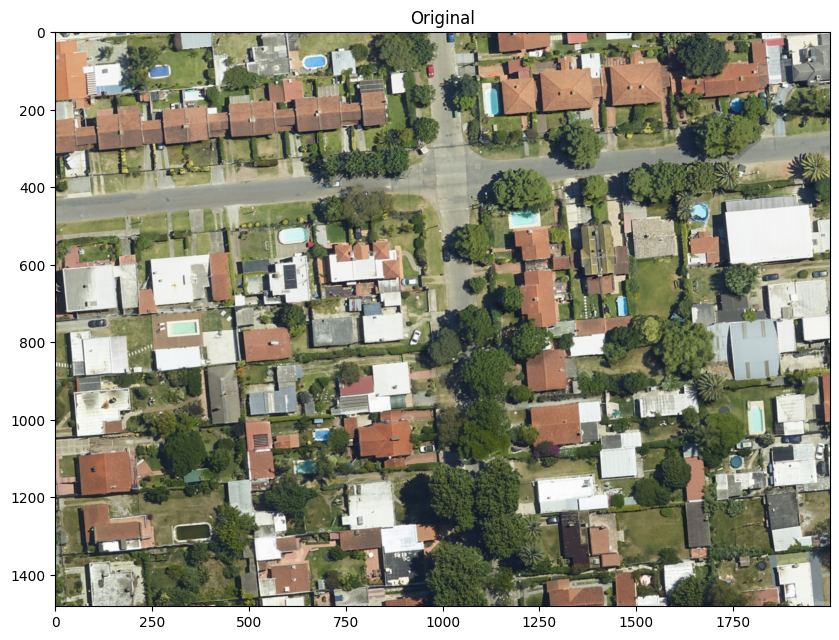

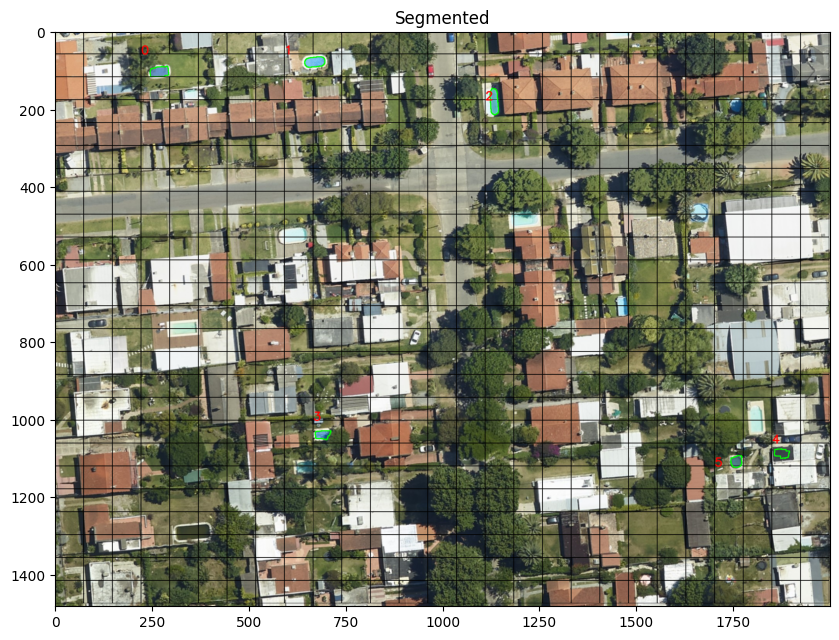

 label  area  perimeter  eccentricity  equivalent_diameter
     0 11.54  14.028427      0.849018             3.833169
     1 12.24  13.984062      0.870777             3.947715
     2 12.51  16.363351      0.953264             3.991018
     3  7.72  11.807716      0.829112             3.135189
     4  7.71  12.121320      0.816737             3.133158
     5  7.49  10.873402      0.489235             3.088133


In [30]:
imag = np.array(Image.open(os.path.join('..', 'data', 'datasets' ,'SIG', 'image_chunk.jpg')))
plt.figure(figsize=(10,10))
plt.imshow(imag)
plt.title('Original')
plt.show()

res = process_image(imag, model(), segmentator(), division_y=25, division_x=27)
plt.figure(figsize=(10,10))
plt.imshow(res[0])
plt.title('Segmented')
plt.show()

print(res[1].to_string(index=False))